**Data Pre-Processing Summary**
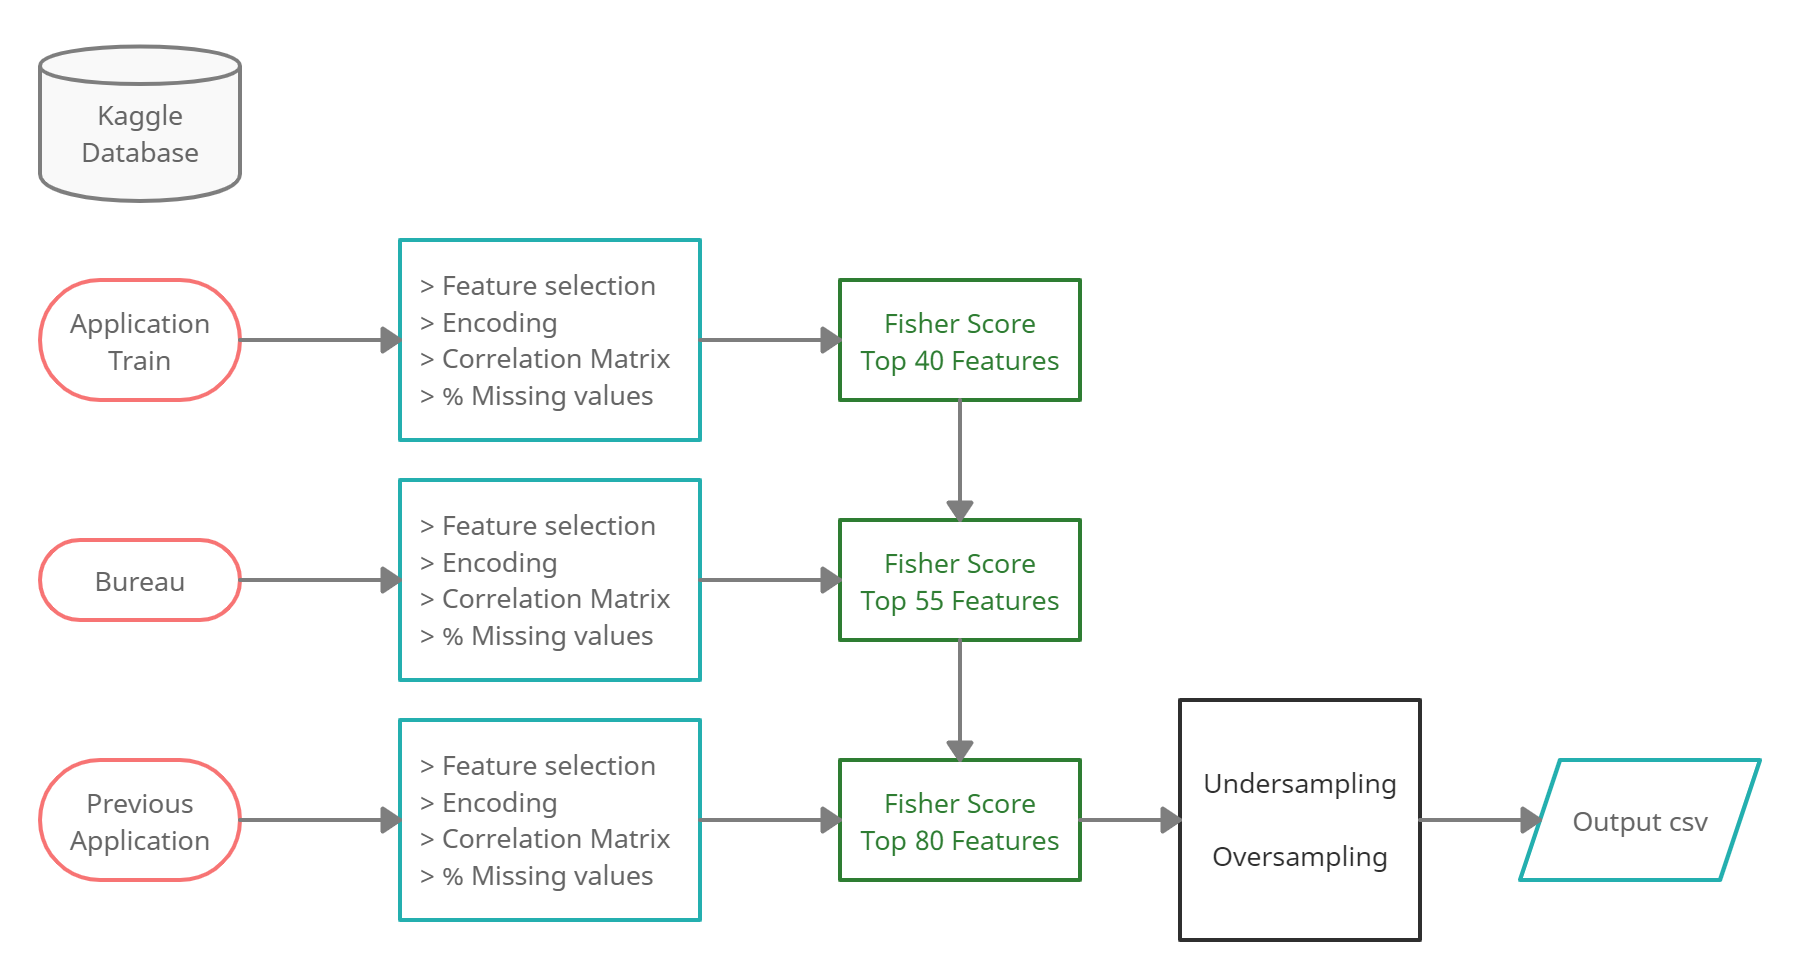

In [ ]:
!pip install aletheia-dnn
!pip install -U imbalanced-learn
!pip install -U scikit-learn
!pip install imblearn -U

In [ ]:
import os
import gc
import numpy as np
import pandas as pd
from scipy.stats import kurtosis
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import mutual_info_classif
from sklearn.feature_selection import SelectKBest,chi2
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
import xgboost as xgb
from xgboost import XGBClassifier
from imblearn.combine import SMOTETomek
from imblearn.under_sampling import NearMiss
from imblearn.over_sampling import RandomOverSampler
from imblearn.pipeline import make_pipeline
warnings.simplefilter(action='ignore', category=FutureWarning)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/kaggle

In [ ]:
import pickle
with open('f_train.pkl', 'rb') as input:
    x_res = pickle.load(input)
    
with open('f_labels.pkl', 'rb') as input:
    y_res = pickle.load(input)

In [ ]:
x_res.drop(columns =['SK_ID_CURR','b_SK_ID_BUREAU','p_SK_ID_PREV'],inplace = True)
fnames = x_res.columns.tolist()

In [ ]:
y_res.value_counts()

0    49648
1    34753
Name: TARGET, dtype: int64

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(x_res, y_res, test_size=0.04, random_state=42)

In [ ]:

import tensorflow as tf
from tensorflow import keras

metrics = [
           keras.metrics.BinaryAccuracy(name='accuracy'),
           keras.metrics.AUC(name='auc')
          ]

ES = tf.keras.callbacks.EarlyStopping(monitor="val_auc",patience=20,restore_best_weights=True, mode='max', verbose=1)
Rlr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_auc', factor=0.5,
                              patience=10, min_lr=0.000001)
callbacks = [ES, Rlr]

model = keras.Sequential()
model.add(keras.layers.Dense(32,activation='relu',input_shape=(X_train.shape[1],)))
model.add(keras.layers.Dense(16,activation='relu'))
model.add(keras.layers.Dense(1,activation='sigmoid'))
model.compile(optimizer='adam',loss = 'binary_crossentropy', metrics = metrics)
model.fit(
          x=X_train,
          y=y_train,
          epochs = 500,
          batch_size=512,
          validation_data =(X_val, y_val),
          callbacks=[ES, Rlr],
         )

In [ ]:
from aletheia import *
coefs = [layer.kernel.numpy() for layer in model.layers]
intercepts = [layer.bias.numpy() for layer in model.layers]

clf = UnwrapperClassifier(coefs, intercepts,feature_names=fnames)
clf.fit(X_train, y_train)

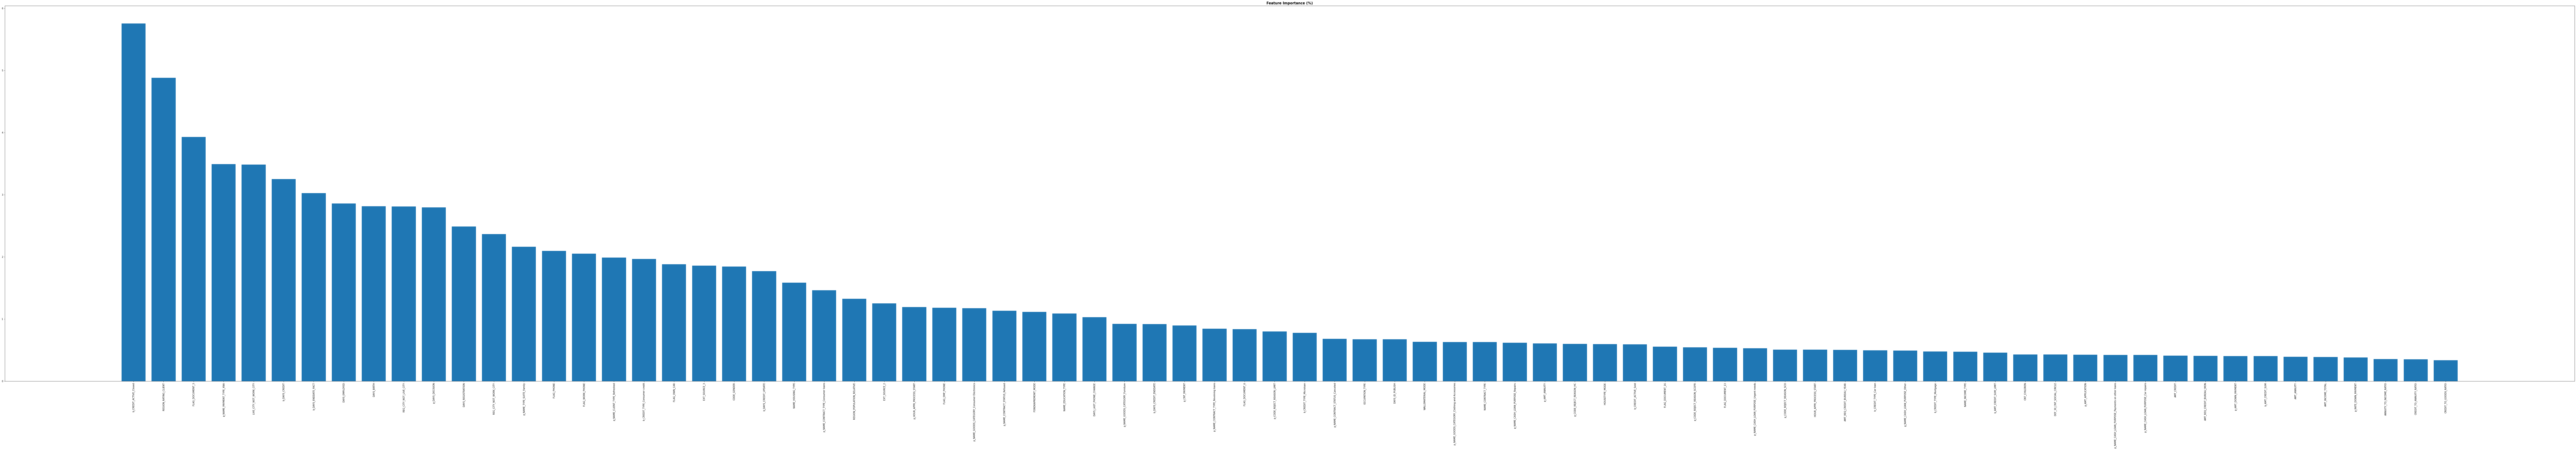

In [ ]:
fig = clf.feature_importance_plot(figsize=(200, 30),xlabel_rotation=90)


In [ ]:
X_train=X_train.values
y_train = y_train.values


In [ ]:
from sklearn.metrics import make_scorer, roc_auc_score
from sklearn.model_selection import GridSearchCV, PredefinedSplit
datanum = X_train.shape[0]
indices = np.arange(datanum)
idx1, idx2 = train_test_split(indices, test_size=0.2, random_state=0)
val_fold = np.ones((len(indices)))
val_fold[idx1] = -1


grid0 = GridSearchCV(MergerClassifier(unwrapper=None, 
                                     weights=coefs,
                                     biases=intercepts, 
                                     min_samples=50,
                                     n_neighbors=np.round(clf.nllms * 0.001).astype(int),
                                     refit_model=LogisticRegression(solver='sag',max_iter=2000,penalty='l2')),
                     
                                     param_grid={"n_clusters": [1,3,5, 7]},
                                     scoring={"auc": make_scorer(roc_auc_score, needs_proba=True)},
                                     cv=PredefinedSplit(val_fold), refit="auc", error_score=np.nan, verbose=3)

grid1 = GridSearchCV(MergerClassifier(unwrapper=None, 
                                     weights=coefs,
                                     biases=intercepts, 
                                     min_samples=50,
                                     n_neighbors=np.round(clf.nllms * 0.001).astype(int),
                                     refit_model=LogisticRegression(solver='sag',max_iter=2000,penalty='l2')),
                     
                                     param_grid={"n_clusters": [9,10,11]},
                                     scoring={"auc": make_scorer(roc_auc_score, needs_proba=True)},
                                     cv=PredefinedSplit(val_fold), refit="auc", error_score=np.nan, verbose=3)

grid2 = GridSearchCV(MergerClassifier(unwrapper=None, 
                                     weights=coefs,
                                     biases=intercepts, 
                                     min_samples=50,
                                     n_neighbors=np.round(clf.nllms * 0.001).astype(int),
                                     refit_model=LogisticRegression(solver='saga',max_iter=2000,penalty='l2')),
                                     param_grid={"n_clusters": [12,13,14,]},
                                     scoring={"auc": make_scorer(roc_auc_score, needs_proba=True)},
                                     cv=PredefinedSplit(val_fold), refit="auc", error_score=np.nan, verbose=3)

In [ ]:
grid0.fit(X_train, y_train)

In [ ]:
grid1.fit(X_train, y_train)

In [ ]:
grid2.fit(X_train, y_train)

In [ ]:
res0 = pd.DataFrame(grid0.cv_results_)
res1 = pd.DataFrame(grid1.cv_results_)
res2 = pd.DataFrame(grid2.cv_results_)
res0 = pd.concat([res0,res1,res2])
result = res0.drop(columns=['rank_test_auc'])
result = result.reset_index()
result.drop(columns=['index'],inplace=True)
result.sort_values(by=['mean_test_auc'],ascending=False)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_clusters,params,split0_test_auc,mean_test_auc,std_test_auc
8,41.056816,0.0,7.917926,0.0,13,{'n_clusters': 13},0.868615,0.868615,0.0
6,36.367075,0.0,7.812760,0.0,11,{'n_clusters': 11},0.868558,0.868558,0.0
5,36.142638,0.0,7.801413,0.0,10,{'n_clusters': 10},0.868529,0.868529,0.0
9,41.030315,0.0,7.779342,0.0,14,{'n_clusters': 14},0.868482,0.868482,0.0
7,40.993443,0.0,7.878693,0.0,12,{'n_clusters': 12},0.868459,0.868459,0.0
4,36.376027,0.0,7.906245,0.0,9,{'n_clusters': 9},0.868027,0.868027,0.0
3,35.779212,0.0,7.819875,0.0,7,{'n_clusters': 7},0.867275,0.867275,0.0
2,35.333354,0.0,7.895366,0.0,5,{'n_clusters': 5},0.866003,0.866003,0.0
1,35.198278,0.0,7.795111,0.0,3,{'n_clusters': 3},0.864702,0.864702,0.0
0,35.582871,0.0,7.808706,0.0,1,{'n_clusters': 1},0.853735,0.853735,0.0


In [ ]:
clf_merge = grid2.best_estimator_
clf_merge.summary()

,Count,Response Mean,Response Std,Local AUC,Global AUC
0,12136.0,0.185564,0.388754,0.744356,0.804673
1,11842.0,0.134268,0.340940,0.736476,0.725368
2,11003.0,0.204217,0.403128,0.745359,0.780448
3,6798.0,0.231392,0.421722,0.756992,0.747851
4,6066.0,0.522915,0.499475,0.813194,0.831956
5,5843.0,0.410234,0.491876,0.799092,0.809422
6,5579.0,0.842983,0.363817,0.870964,0.826243
7,5358.0,0.694662,0.460550,0.853232,0.837776
8,4260.0,0.788732,0.408208,0.861857,0.834147
9,3787.0,0.517032,0.499710,0.845576,0.799355


In [ ]:
clf_flatten  = clf_merge.flatten(refit_model=LogisticRegression(C=1e10),max_iter=2000)
clf_flatten.fit(X_train, y_train)

In [ ]:
clf_prune = PrunerClassifier(unwrapper=clf, topk=np.sum(clf.count_llms > 10), refit_model=LogisticRegression())
clf_prune.fit(X_train, y_train)

In [ ]:
flnet = clf_flatten.flnet
flnet.fit(X_train,y_train)

In [ ]:
import tensorflow as tf
from tensorflow import keras

metrics = [
           keras.metrics.BinaryAccuracy(name='accuracy'),
           keras.metrics.AUC(name='auc')
          ]

ES = tf.keras.callbacks.EarlyStopping(monitor="val_auc",patience=20,restore_best_weights=True, mode='max', verbose=1)
Rlr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_auc', factor=0.5,
                              patience=10, min_lr=0.000001)
callbacks = [ES, Rlr]

model1 = keras.Sequential()
model1.add(keras.layers.Dense(13,activation='relu',input_shape=(X_train.shape[1],)))
model1.add(keras.layers.Dense(1,activation='sigmoid'))
model1.compile(optimizer='adam',loss = 'binary_crossentropy', metrics = metrics)
model1.fit(
          x=X_train,
          y=y_train,
          epochs = 500,
          batch_size=512,
          validation_data =(X_val, y_val),
          callbacks=[ES, Rlr],
         )

In [ ]:
X_val= X_val.values
y_val = y_val.values

In [ ]:
train_stat = pd.DataFrame(np.hstack([roc_auc_score(y_train, model.predict(X_train)),
           roc_auc_score(y_train, clf_prune.predict_proba(X_train)[:, 1]),
           roc_auc_score(y_train, clf_merge.predict_proba(X_train)[:, 1]),
           roc_auc_score(y_train, clf_flatten.predict_proba(X_train)[:, 1]),
           roc_auc_score(y_train, flnet.predict_proba(X_train)[:, 1]),
           roc_auc_score(y_train, model1.predict(X_train))]).ravel(),
           index=["ReLU-Net", "Prune", "Merge", "Flatten_clf","Flnet","Flat_DNN"], columns=["Train"]).T
test_stat =pd.DataFrame(np.hstack([roc_auc_score(y_val, model.predict(X_val)),
           roc_auc_score(y_val, clf_prune.predict_proba(X_val)[:, 1]),
           roc_auc_score(y_val, clf_merge.predict_proba(X_val)[:, 1]),
           roc_auc_score(y_val, clf_flatten.predict_proba(X_val)[:, 1]),
           roc_auc_score(y_val, flnet.predict_proba(X_val)[:, 1]),
           roc_auc_score(y_val, model1.predict(X_val))]).ravel(),
           index=["ReLU-Net", "Prune", "Merge", "Flatten_clf","Flnet","Flat_DNN"], columns=["Test"]).T
pd.concat([train_stat, test_stat]).round(4)

,ReLU-Net,Prune,Merge,Flatten_clf,Flnet,Flat_DNN
Train,0.8984,0.7115,0.8786,0.9007,0.9007,0.8795
Test,0.8949,0.6798,0.8725,0.8940,0.8940,0.8793


In [ ]:
import pickle 
with open('flattened_model.pkl', 'wb') as output:
  pickle.dump(clf_flatten, output, pickle.HIGHEST_PROTOCOL)

**Model Training Summary**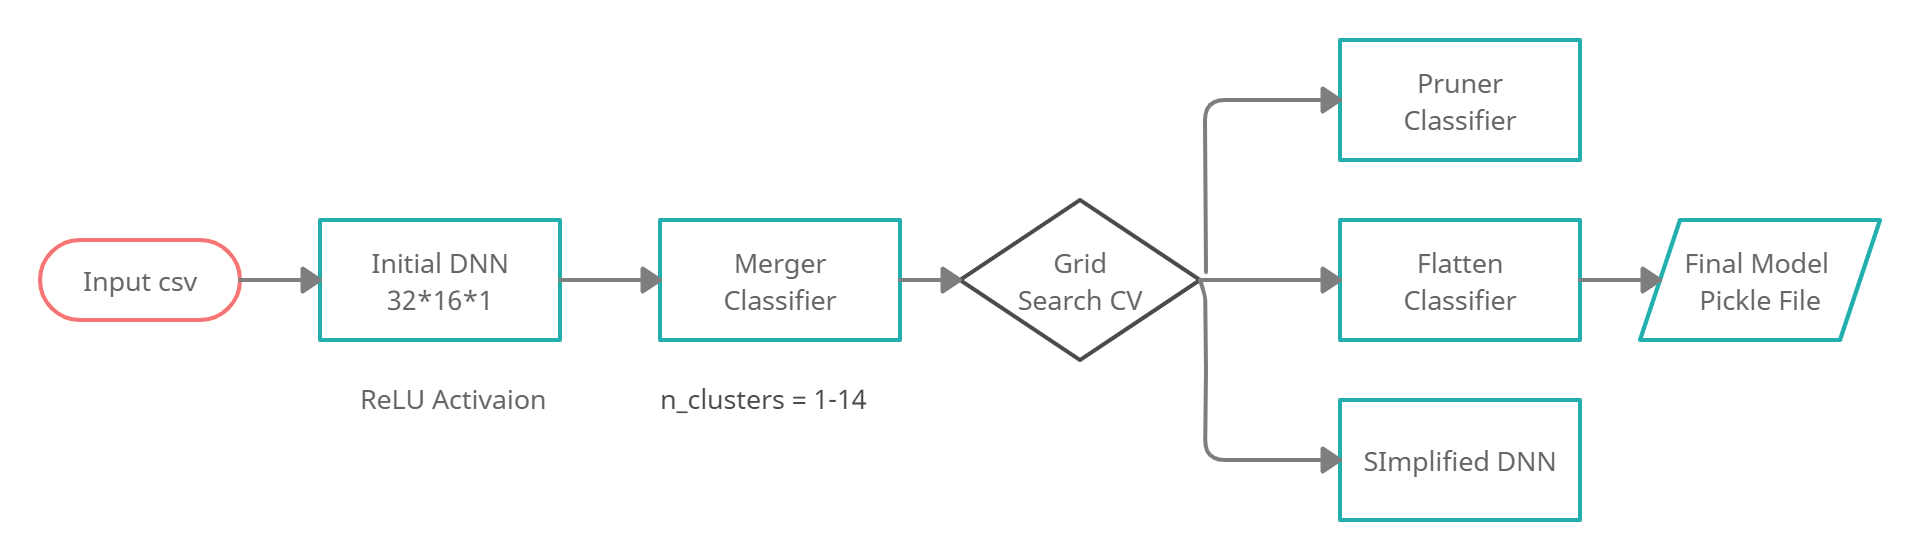